<a href="https://colab.research.google.com/github/cisirtraining/summerschool/blob/master/uNet_prostate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Mount Google Drive for Data Access**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Libraries

In [3]:
from __future__ import print_function
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
import warnings
warnings.filterwarnings('ignore')


from keras.optimizers import Adam, SGD
from keras.callbacks import  ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.utils import to_categorical

from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix

#Make sure we remove any randomness
from numpy.random import seed
seed(1)

try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Display images and shapes for sanity check

In [0]:
#Show an originalimage
image = cv2.imread('./drive/My Drive/data/33.png',0)
#Show corresponding mask

mask = cv2.imread('./drive/My Drive/data/33_mask.png',0)

plt.figure(figsize=(15,15))
ax = plt.subplot(1, 2, 1)
ax.set_title('Image')
ax.imshow(image, cmap=cm.Greys_r, interpolation='none')
ax.axis('off')
ax = plt.subplot(1, 2, 2)
ax.set_title('Mask')
ax.imshow(mask,cmap=cm.Greys_r, interpolation='none')
ax.axis('off')


In [0]:
print ('Image shape: ',image.shape)
print ('Mask shape: ',mask.shape)
seg_map = cv2.imread('./drive/My Drive/data/33_mask.png',0)
print('Unique mask:',np.unique(seg_map))

## Visualize the mask for all segments

In [0]:
binary_mask = to_categorical(mask, num_classes=3)
print ('Binary shape: ',binary_mask.shape)

plt.figure(figsize=(20,20))
ax = plt.subplot(1, 3, 1)
ax.set_title('Background')
ax.imshow(binary_mask[...,0])
ax.axis('off')
ax = plt.subplot(1, 3, 2)
ax.set_title('Peripheral_Zone')
ax.imshow(binary_mask[...,1])
ax.axis('off')
ax = plt.subplot(1, 3, 3)
ax.set_title('Central_Zone')
ax.imshow(binary_mask[...,2])
ax.axis('off')

In [0]:
def create_label_colormap():
    """Creates a label colormap used in OA_ZIB masks.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [160, 160,160],   
        [209, 14, 47], 
        [255,255,255]],dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


LABEL_NAMES = np.asarray([
    'Background','Peripheral_Zone','Central_Zone'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
print('label map:\n',FULL_LABEL_MAP)
print('color map:\n',FULL_COLOR_MAP)

## Data Generators


In [0]:
# def custom_image_generator(generator, directory, seed=None, batch_size=16,  target_size=(320, 320),
#                            color_mode="grayscale", class_mode=None, isMask=False, num_classes=3):
#     """
#     Read images from a dirctory batch-size wise
#     If images are masks (e.g. 384x384x1) then convert them to multi-label arrays (e.g. 384x384x3) so that they match the output of UNet 
#     """
#     import numpy as np
    
#     #Read from directory (flow_from_directory)
#     iterator = generator.flow_from_directory(directory=directory,
#                                              target_size=target_size,
#                                              color_mode=color_mode,
#                                              class_mode=class_mode,
#                                              batch_size=batch_size,
#                                              seed=seed)


    
#     for batch_x in iterator:
#         #if image is a mask convert to a multi-label array (binary matrix: m x m x nb_class)
#         if isMask==True:
#             batch_x=to_categorical(batch_x, num_classes)
#         yield batch_x

In [0]:
# #Random seed set into a fixed value to apply same augmentations to images and masks. Otherwise they would not be the same.
# seed=1 

# #Set the batch size
# batch_size= 16


# #Create the image training generator
# image_train_datagen = custom_image_generator(
#             ImageDataGenerator(rotation_range=0.,  #Augmentation 1: Rotate images randomly within +- 20 degrees
#                      width_shift_range=0.1, #Augmentation 2: Translate image left or right by 10% 
#                      height_shift_range=0.1,  #Augmentation 3: Translate image up or down by 10% 
#                      rescale=1./255.), #Augmentation 4: Zoom in/out 20% 
#             directory='zia/ori/train/train_images/',  #Directory holding the raw images
#             seed=seed, #Use a specific random seed
#             target_size=(320,320), #Resize images if needed to fit into the Input layer of Unet
#             color_mode='grayscale', #Load them as one-channel (i.e. grayscale)
#             batch_size=batch_size, #Use batch size of 32
# )

# #Create the mask training generator
# mask_train_datagen = custom_image_generator(
#             ImageDataGenerator(rotation_range=0.,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1),
#             directory='zia/ori/train/train_masks/',
#             seed=seed,
#             target_size=(320,320),
#             color_mode='grayscale',
#             batch_size=batch_size,
#             isMask=True
# )


# #Create the image validation generator
# image_val_datagen = custom_image_generator(
#             ImageDataGenerator(rescale=1./255.),
#             directory='zia/ori/valid/valid_images/',
#             seed=seed,
#             target_size=(320,320),
#             color_mode='grayscale',
#             batch_size=batch_size,
        
#         )

# #Create the mask validation generator
# mask_val_datagen = custom_image_generator(
#             ImageDataGenerator(),
#             directory='zia/ori/valid/valid_masks/',
#             seed=seed,
#             target_size=(320,320),
#             color_mode='grayscale',
#             batch_size=batch_size,
#             isMask=True,
           
#         )

# #Create the image test generator
# image_test_datagen = custom_image_generator(
#             ImageDataGenerator(rescale=1./255.),
#             directory='zia/ori/test/test_images/',
#             seed=seed,
#             target_size=(320,320),
#             color_mode='grayscale',
#             batch_size=batch_size,
           
#         )

# #Create the mask test generator
# mask_test_datagen = custom_image_generator(
#             ImageDataGenerator(),
#             directory='zia/ori/test/test_masks/',
#             seed=seed,
#             target_size=(320,320),
#             color_mode='grayscale',
#             batch_size=batch_size,
#             isMask=True,
            
#         )

# # combine generators into one which yields image and images
# train_generator = zip(image_train_datagen, mask_train_datagen)
# val_generator = zip(image_val_datagen, mask_val_datagen)
# test_generator = zip(image_test_datagen, mask_test_datagen)

##**Load Dataset**


*   Load images stored in img.npy and associated masks stored in masks.npy


In [0]:
# load dataset

X = np.load('./drive/My Drive/data/img.npy') # images
Y = np.load('./drive/My Drive/data/mask.npy') # masks

print('\n**** data loaded ****')


## One Hot Encode the Masks

In [0]:
# Normalize the data
X_test = X/255.
Y_test = Y


# Convert to one-hot-encoded
num_classes = 3
Y_test = to_categorical(Y_test, num_classes)

print("Testing Image Shape:", X_test.shape)
print("Testing Mask Shape:", Y_test.shape)



##**Model Training**
>### Batch-Norm U-Net

![](https://drive.google.com/uc?id=1372zdn01YaOD3VheC2763A9nLeI1d4Mq)

In [0]:
from keras.models import Model
from keras.layers import Input,  concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization

def generate_batch_norm_unet(base_num_filters, num_classes, kernel_size=(3,3), image_width=320, image_height=320):
        """
        UNet with batch normalization
        """
        inputs = Input((image_height, image_width, 1))
        conv1 = Conv2D(base_num_filters, kernel_size, activation='relu', padding='same')(inputs)
        bn1 = BatchNormalization()(conv1)
        conv1 = Conv2D(base_num_filters, kernel_size, activation='relu', padding='same')(bn1)
        bn1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

        conv2 = Conv2D(2 * base_num_filters, kernel_size, activation='relu', padding='same')(pool1)
        bn2 = BatchNormalization()(conv2)
        conv2 = Conv2D(2 * base_num_filters, kernel_size, activation='relu', padding='same')(bn2)
        bn2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

        conv3 = Conv2D(4 * base_num_filters, kernel_size, activation='relu', padding='same')(pool2)
        bn3 = BatchNormalization()(conv3)
        conv3 = Conv2D(4 * base_num_filters, kernel_size, activation='relu', padding='same')(bn3)
        bn3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

        conv4 = Conv2D(8 * base_num_filters, kernel_size, activation='relu', padding='same')(pool3)
        bn4 = BatchNormalization()(conv4)
        conv4 = Conv2D(8 * base_num_filters, kernel_size, activation='relu', padding='same')(bn4)
        bn4 = BatchNormalization()(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

        conv5 = Conv2D(16 * base_num_filters, kernel_size, activation='relu', padding='same')(pool4)
        bn5 = BatchNormalization()(conv5)
        conv5 = Conv2D(16 * base_num_filters, kernel_size, activation='relu', padding='same')(bn5)
        bn5 = BatchNormalization()(conv5)
        drop = Dropout(0.5)(bn5)

        up6 = concatenate([Conv2DTranspose(8*base_num_filters, kernel_size, strides=(2, 2), padding='same')(drop), conv4], axis=3)
        conv6 = Conv2D(8 * base_num_filters, kernel_size, activation='relu', padding='same')(up6)
        bn6 = BatchNormalization()(conv6)
        conv6 = Conv2D(8 * base_num_filters, kernel_size, activation='relu', padding='same')(bn6)
        bn6 = BatchNormalization()(conv6)

        up7 = concatenate([Conv2DTranspose(4*base_num_filters, kernel_size, strides=(2, 2), padding='same')(bn6), conv3], axis=3)
        conv7 = Conv2D(4 * base_num_filters, kernel_size, activation='relu', padding='same')(up7)
        bn7 = BatchNormalization()(conv7)
        conv7 = Conv2D(4 * base_num_filters, kernel_size, activation='relu', padding='same')(bn7)
        bn7 = BatchNormalization()(conv7)

        up8 = concatenate([Conv2DTranspose(2*base_num_filters, kernel_size, strides=(2, 2), padding='same')(bn7), conv2], axis=3)
        conv8 = Conv2D(2 * base_num_filters, kernel_size, activation='relu', padding='same')(up8)
        bn8 = BatchNormalization()(conv8)
        conv8 = Conv2D(2 * base_num_filters, kernel_size, activation='relu', padding='same')(bn8)
        bn8 = BatchNormalization()(conv8)

        up9 = concatenate([Conv2DTranspose(base_num_filters, kernel_size, strides=(2, 2), padding='same')(bn8), conv1], axis=3)
        conv9 = Conv2D(base_num_filters, kernel_size, activation='relu', padding='same')(up9)
        bn9 = BatchNormalization()(conv9)
        conv9 = Conv2D(base_num_filters, kernel_size, activation='relu', padding='same')(bn9)
        bn9 = BatchNormalization()(conv9)

        conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(bn9)

        model = Model(inputs=[inputs], outputs=[conv10])

        return model

## Callbacks (e.g. save logs, save best model)

In [0]:
#Save UNet model on smallest validation loss
model_checkpoint = ModelCheckpoint('unet_prostate.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reducer = ReduceLROnPlateau(monitor='val_loss', factor=.2, patience=50, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

#Save logs to file
logger = CSVLogger('unet_prostatelatest.txt', separator=',', append=False)

#Put the 2 callbacks together
callbacks = [model_checkpoint,reducer,logger]


## Training / Validation 

In [0]:
# from keras import backend as K
# import tensorflow as tf
# import time

# smooth = 1.

# train_steps_per_epoch = np.ceil(10000/ batch_size)
# val_steps_per_epoch = np.ceil(2000/batch_size)

# def dice_coef(y_true,y_pred):
#   smooth = 1
#   y_true_f = K.flatten(y_true)
#   y_pred_f = K.flatten(y_pred)
#   intersection = K.sum(y_true_f * y_pred_f)
#   return (2. * intersection + smooth)/(K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)


# # loss
# def mean_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

# def dice_coef_loss (y_true,y_pred):
#     return 1. - dice_coef(y_true,y_pred)

# start_time = time.time()

# optmzr = SGD(lr=0.01,momentum=0.9,nesterov=True)

# model.compile(optimizer=optmzr, 
#               loss= [dice_coef_loss], 
#               metrics=["accuracy", mean_iou, dice_coef])

# history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=250,validation_data=val_generator, validation_steps=val_steps_per_epoch, callbacks=callbacks, verbose=1, workers=10, use_multiprocessing=True)

# end_time = time.time()
# hours, rem = divmod(end_time - start_time,3600)
# minutes, seconds = divmod(rem,60)
# print('Execution Time:')
# print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'val_mean_iou', 'val_dice_coef', 'loss', 'acc', 'mean_iou', 'dice_coef', 'lr'])


##**Plot Learning Curve**

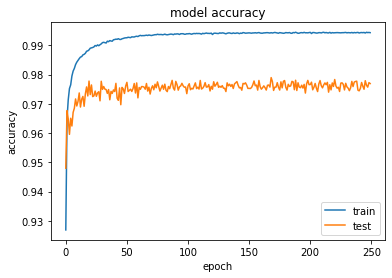

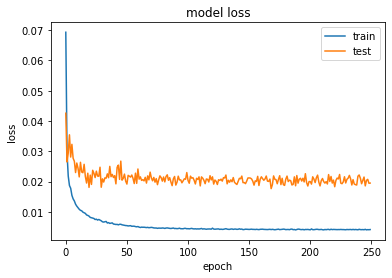

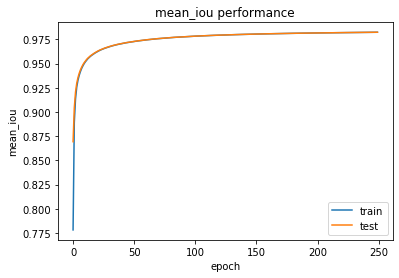

In [0]:
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib import gridspec

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# summarize history for loss
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('mean_iou performance')
plt.ylabel('mean_iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

    

# Evaluate Model

In [11]:
#Generate UNet with base number of filters and number of labels for segmntation
# model = generate_batch_norm_unet(base_num_filters=32, num_classes=3, kernel_size=(3,3))


def dice_coef(y_true,y_pred):
  smooth = 1
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth)/(K.sum(K.square(y_true_f)) + K.sum(K.square(y_pred_f)) + smooth)


# loss
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef_loss (y_true,y_pred):
    return 1. - dice_coef(y_true,y_pred)

#load trained moded:
model = keras.models.load_model('./drive/My Drive/data/unet_prostate.h5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef, 'mean_iou':mean_iou})

print (model.summary())

W0817 13:32:22.927003 140303827814272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0817 13:32:22.954926 140303827814272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0817 13:32:22.988593 140303827814272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0817 13:32:22.989915 140303827814272 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0817 13:32:22.991694 140303827

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 320, 320, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [0]:
# model = keras.models.load_model('unet_prostatelatest.h5',custom_objects={'dice_coef_loss':dice_coef_loss,'dice_coef':dice_coef, 'mean_iou':mean_iou})

# val_steps_per_epoch = 2000/batch_size

# print("\n\n==================  Evaluate the results ====================")

# score = model.evaluate_generator(val_generator,steps=val_steps_per_epoch,workers=10, use_multiprocessing=True, verbose=1)
# print ('\nValidation loss:',score[0])
# print('Accuracy:',score[1])
# print('Dice score:',score[2])



==================  Evaluate the results ====================
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
Found 2000 images belonging to 1 classes.
125/125 [==============================] - 37s 297ms/step

Validation loss: 0.020859003543853758

## Visualization

In [0]:
import keras
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib import gridspec
from skimage import io, color, img_as_float
from skimage.exposure import adjust_gamma
from skimage.segmentation import mark_boundaries
import cv2
import warnings
warnings.filterwarnings('ignore')

img_h =320
img_w=320
n_labels =3


image = X_test # evaluate on 1st 16 images
mask = Y_test

segmentation = model.predict(image).argmax(axis=3)
mask = mask.argmax(axis=3)


print("\n\n==================  Result visualization ====================")

for img, sgm, msk in zip(image, segmentation, mask):
    
    
    ones = np.argwhere(sgm == 1)
    twos = np.argwhere(sgm == 2)
    

    # adjust gamma of image

    img = adjust_gamma(img, 0.75)
    sliced_image = img.copy()
    sliced_image = sliced_image[...,0]
    overlay_seg = np.stack((sliced_image,)*3, axis=-1)
    
    # define color for each ROI 
    cz_color = [209/255,14/255, 47/255]
    pz_color = [255/255, 255/255, 255/255]
   
  
    # change colors of segmented classes
    for i in range(len(ones)):
        overlay_seg[ones[i][0]][ones[i][1]] = cz_color
    for i in range(len(twos)):
        overlay_seg[twos[i][0]][twos[i][1]] = pz_color
    
 
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 5, width_ratios=[6, 6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(img[...,0],cmap=cm.Greys_r, interpolation='none')
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_msk = label_to_color_image(msk).astype(np.uint8)
    plt.imshow(seg_msk)
    plt.axis('off')
    plt.title('ground truth')
    
    plt.subplot(grid_spec[2])
    seg_image = label_to_color_image(sgm).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('prediction')
    
    plt.subplot(grid_spec[3])
    plt.imshow(overlay_seg)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[4])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

# Performance
### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [0]:
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm import tqdm_notebook as tqdm



def evaluate_image(seg, ground_truth):
    smooth =1

    # calculate accuracy on valid area
    acc = (np.sum(seg[ground_truth!=3]==ground_truth[ground_truth!=3])/np.sum(ground_truth!=3))
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=3], seg[ground_truth!=3],
                          labels=np.array([0,1,2]))
    
    intersection = np.diag(cm) # true positive
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)  
    TP = np.diag(cm)
    FP = np.sum(cm,1) - np.diag(cm)
    FN = np.sum(cm,0) - np.diag(cm)
    precision = (TP + smooth)/ (TP + FP + smooth)
    recall = (TP + smooth)/(TP + FN + smooth)
    f1 = 2* ((precision*recall)/(precision + recall))
    iou = (intersection + smooth)/(union + smooth)

    return acc, intersection, union,precision, recall,iou, f1


def dice_scores(pred, gts, empty_score=[1.,1.]):
    dice = []
    smooth = 1.
    
    if pred.shape != gts.shape:
        raise ValueError("Shape mismatch: pred and gts must have the same shape.")

    im_sum = np.sum(pred) + np.sum(gts)
    if im_sum == 0:
        return empty_score

    for i in range(2):
        intersect = np.sum((pred == i+1)*(gts == i+1))
        denom = np.sum((pred == i+1)) + np.sum((gts == i+1))
        dice.append((2*intersect + smooth)/(denom + smooth))
        
    return dice

accuracy =[]
IoU = []
prec = []
rec = []
dice_Score = []
F1 =[]

print('\n\n==================  Evaluation of test dataset ====================')
# print('\nclass dice score:')

batch_size = 10
index = np.ceil(70/batch_size).astype(np.int64)

start_time = time.time()

for count in tqdm(range(index), desc ='Progress'):

#     image, mask = next(test_generator)

    image = X_test # evaluate on 1st 16 images
    mask = Y_test
    
    segmentation = model.predict(image).argmax(axis=3)
    mask = mask.argmax(axis=3)

    for img, sgm, msk in zip(image, segmentation, mask):
        

        acc,intersection, union,precision,recall,iou, f1= evaluate_image(sgm,msk)
        
        mean_square_err,struc_similarity = compare_image(sgm,msk)
        dice = dice_scores(sgm,msk)
        dice_Score.append(dice)
    
        accuracy.append(np.round(acc,3))
        prec.append(np.round(precision,3))
        rec.append(np.round(recall,3))
        F1.append(np.round(f1,3))
        IoU.append(np.round(iou,3))
        
        


np.set_printoptions(precision=2)

IoU = np.array(IoU)
prec = np.array(prec)
rec = np.array(rec)
dice_Score = np.array(dice_Score)
F1 = np.array(F1)

end_time = time.time()
hours, rem = divmod(end_time - start_time,3600)
minutes, seconds = divmod(rem,60)
print('Execution Time:')
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [0]:
print('\n================== global performance ====================\n')

print("mean pixel accuracy:",np.mean(accuracy, axis=0))

print('\n***** IoU *****:')
print('mean  :', np.mean(IoU[:,1:],0))
print('median:', np.median(IoU[:,1:],0))

print('\n***** Precision *****:')
print('mean  :', np.mean(prec[:,1:],0))
print('median:', np.median(prec[:,1:],0))

print('\n***** F1 Score *****:')
print('mean  :', np.mean(F1[:,1:],0))
print('median:', np.median(F1[:,1:],0))

print('\n***** Recall *****:')
print('mean  :', np.mean(rec[:,1:],0))
print('median:', np.median(rec[:,1:],0))


print('\n***** Dice Score *****:')
print('mean  :',np.mean(dice_Score, 0))
print('median:',np.median(dice_Score,0))


print("\nExec time: {} minutes".format((np.round(time.time() - start_time, 2))/60))

In [0]:
import pylab

df1 = np.array(dice_Score)


fig, ax1 = plt.subplots(figsize=(8, 4))
bp = ax1.boxplot(df1,0,'', patch_artist=True, autorange=True, showmeans=True)


## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=1)
    # change fill color
    box.set( facecolor = '#0053a0' )
    
## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#ede800', linewidth=2)


ax1.set_title('Dice score for all regions',fontsize=14)
ax1.set_xlabel('Region',fontsize=14)
ax1.set_ylabel('Dice ',fontsize=14)
ax1.set_xticklabels(('PZ', 'CZ'),fontsize=12)
ax1.tick_params(axis='y', labelsize=12)
plt.show()

In [0]:
import seaborn as sns
from scipy.stats import norm

df = np.array(dice_Score)
df.shape
x1 = df[:,0]
x2 = df[:,1]

sns.distplot(x1,color = "deeppink",kde=False)
plt.title('Histogram of PZ Dice Score')
plt.ylabel('Frequency')
plt.xlabel('Dice Score')
plt.show()

sns.distplot(x2,color = "darkgreen",kde=False)
plt.title('Histogram of CZ Dice Score')
plt.ylabel('Frequency')
plt.xlabel('Dice Score')
plt.show()
